In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
load = torch.load('exercise3_stereo_pytorch.pth')
fixed = load['fixed'].unsqueeze(0)
moving = load['moving'].unsqueeze(0).unsqueeze(0)
data = load['data']


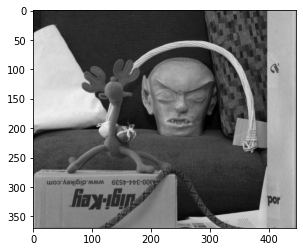

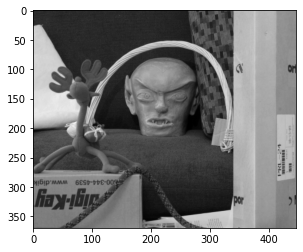

In [3]:
# visualize input data
plt.imshow(fixed.squeeze(0),'gray')
plt.show()
plt.imshow(moving.squeeze(),'gray')
plt.show()

In [4]:
# Aufgabe 1
small_dim = False
if small_dim:
    H,W,K = 3,3,2
    moving = torch.arange(H * W, dtype=torch.float32).view(H,W).unsqueeze(0).unsqueeze(0)
    fixed = torch.arange(H * W, dtype=torch.float32).view(H,W).unsqueeze(0)

else:
    K = 67 # Number of possible Pixel disparities
    H, W = moving.shape[-2:]

weights_moving = torch.linspace(-0.5, 0.5, 3).repeat(1, K, 1, 1)
weights_fixed = torch.linspace(-0.5, 0.5, 3).view(1,1,1,3)

def compute_stereo_data_term(fixed, moving):
    beta = 0.11
    gamma = 7.0
    delta = 2.0

    """
    Unfold liefert uns alle möglichen Kombinationen unseres patches, der in das Bild passt.
    Beispiel 3x3 --> 9 Values pro patch, gibt bei einem 3x4 Bild genau 2 mögliche positionen.
    Wir bekommen dann die Werte innerhalb des Fensters, jedoch zunächst 9x2 matrix, also nur
    2 Werte pro Spalte. Daher noch transponieren der 1 und 2 dim des Tensors.
    Danach bekommen wir eine Matrix mit shape 2x9.
    Anschließend reshapen wir das ganze zu unserem Bild, da uns ja nun nur die möglichen
    Verschiebungen in x-Richtung interessieren.
    """
    padded_moving = F.pad(moving, [K-1, 0]) # padded with 0 in x-direction
    unfolded_moving = F.unfold(padded_moving, (H,W))
    unfolded_moving = unfolded_moving.transpose(1, 2)# Bekommen genau die 67 möglichen patches
    unfolded_moving = unfolded_moving.view(K,H,W)

    # Faltung in x-Richtung. Achtung wir haben sogesehen 67 channel hier.
    unfolded_moving_gradient = F.conv2d(unfolded_moving.unsqueeze(0), weights_moving, padding=(0, 1)).squeeze(0).squeeze(0)
    fixed_gradient = F.conv2d(fixed.unsqueeze(0),weights_fixed,padding=(0, 1)).squeeze(0).squeeze(0)

    # Gleichung berechnen
    part_1 = beta * torch.clamp(torch.abs(fixed - unfolded_moving), max=gamma)
    part_2 = (1 - beta) *  torch.clamp(torch.abs(fixed_gradient - unfolded_moving_gradient), max = delta)


    return part_1 + part_2




D_y = compute_stereo_data_term(fixed, moving)

In [13]:
# Aufgabe 2 & 3
import torch

lecture = False
data_costs = torch.tensor(
                    [[0.5, 1.0, 3.0, 2.5, 1.5],
                     [3.0, 3.5, 1.5, 0.5, 2.0],
                     [2.0, 1.5, 1.0, 2.0, 4.0],
                     [2.0, 1.0, 3.0, 3.5, 1.0]])

def calc_shortest_path(input_costs: torch.Tensor, backward: bool =  False, K: int = 5, M: int = 0,
                       N: int = 4, max_regularizer = 100):
    path = torch.zeros_like(input_costs)
    if backward: input_costs = torch.flip(input_costs,dims=2)

    regularizer = torch.arange(K)
    regularizer_matrix = torch.stack([torch.clamp(torch.abs(regularizer - j).float(), max=max_regularizer) for j in range(K)])
    if M > 0: regularizer_matrix = regularizer_matrix.unsqueeze(2).repeat(1, 1, M)

    for i in range(N):
        if i == 0:
            path[:, :, i] = input_costs[:, :, i]
        else:
            past_path_matrix = path[:, :, i-1] + regularizer_matrix
            past_path_matrix = torch.min(input=past_path_matrix,dim=1).values
            path[:, :, i] = input_costs[:, :, i] + past_path_matrix

    return  torch.flip(path,dims=2) if backward else path


if lecture:
    # Aufgabe 2 --> Change Boolean lecture to true, and Loop index to [i] to compute data from lecture
    forward_path = calc_shortest_path(input_costs=data_costs)
    backward_path = calc_shortest_path(input_costs=data_costs,backward=True)

    combined_costs = forward_path + backward_path - data_costs
    print('Computed Task 2:\n', combined_costs)
else:
    # Aufgabe 3 --> Change Boolean lecture to False, and Loop index to [:, :, i] to compute in image data
    k,m,n = D_y.shape
    forward_path = calc_shortest_path(input_costs=D_y,backward=False,K=k, M=m,N=n,max_regularizer=3.5)
    backward_path = calc_shortest_path(input_costs=D_y,backward=True,K=k, M=m,N=n,max_regularizer=3.5)
    combined_costs = forward_path + backward_path - D_y
    print('Computed Task 3')

TypeError: flip(): argument 'dims' must be tuple of ints, not int

In [27]:
# task 3 - jesse
idx_K = torch.arange(K, dtype=float).unsqueeze(0).repeat(K, 1)
idx_K_rev = idx_K.transpose(1,0)
regular = torch.abs(idx_K - idx_K_rev)
regular = torch.where(regular <= torch.tensor(3.5, dtype=torch.double), regular, torch.tensor(3.5, dtype=torch.double))
regular = regular.unsqueeze(2).repeat(1,1,H)

# forward path:
forward = torch.zeros_like(D_y)
forward[:,:,0] = D_y[:,:,0]
b = torch.zeros([K, H, W])

for i in range(0,W-1):
    all_costs = forward[:,:,i].repeat(K,1,1)+regular
    costs, b_i = torch.min( all_costs , dim=1)
    forward[:,:,i+1] = D_y[:,:,i+1] + costs
    b[:,:,i] = b_i

#backward path:
backward = torch.zeros_like(D_y)
backward[:,:,-1] = D_y[:,:,-1]
for i in range(W-2,-1, -1):
    all_costs = backward[:,:,i+1].repeat(K,1,1)+regular
    costs,_ = torch.min( all_costs , dim=1)
    backward[:,:,i] = D_y[:,:,i] + costs
    

comb_costs = forward + backward - D_y

KeyboardInterrupt: 

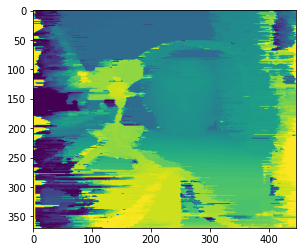

In [12]:
optimal_disparity= -torch.argmin(combined_costs, dim=0)



plt.imshow(optimal_disparity)
plt.show()